In [1]:
import pandas as pd
import boutAnalysis

df = pd.read_csv('Shimbo_RIO_DATA_EXP_051323.csv')
df["Timestamp"] = ["0" + timestamp + ":00" if len(timestamp) == 4 else "0" + timestamp for timestamp in df["Timestamp"]]

df = df.sort_values(by=["Period", "Timestamp"], ascending=[True, False])

my_score = boutAnalysis.get_score(df, "For")
opp_score = boutAnalysis.get_score(df, "Against")
print(f'Score: {my_score} x {opp_score}')

Score: 9 x 15


# Timeline 

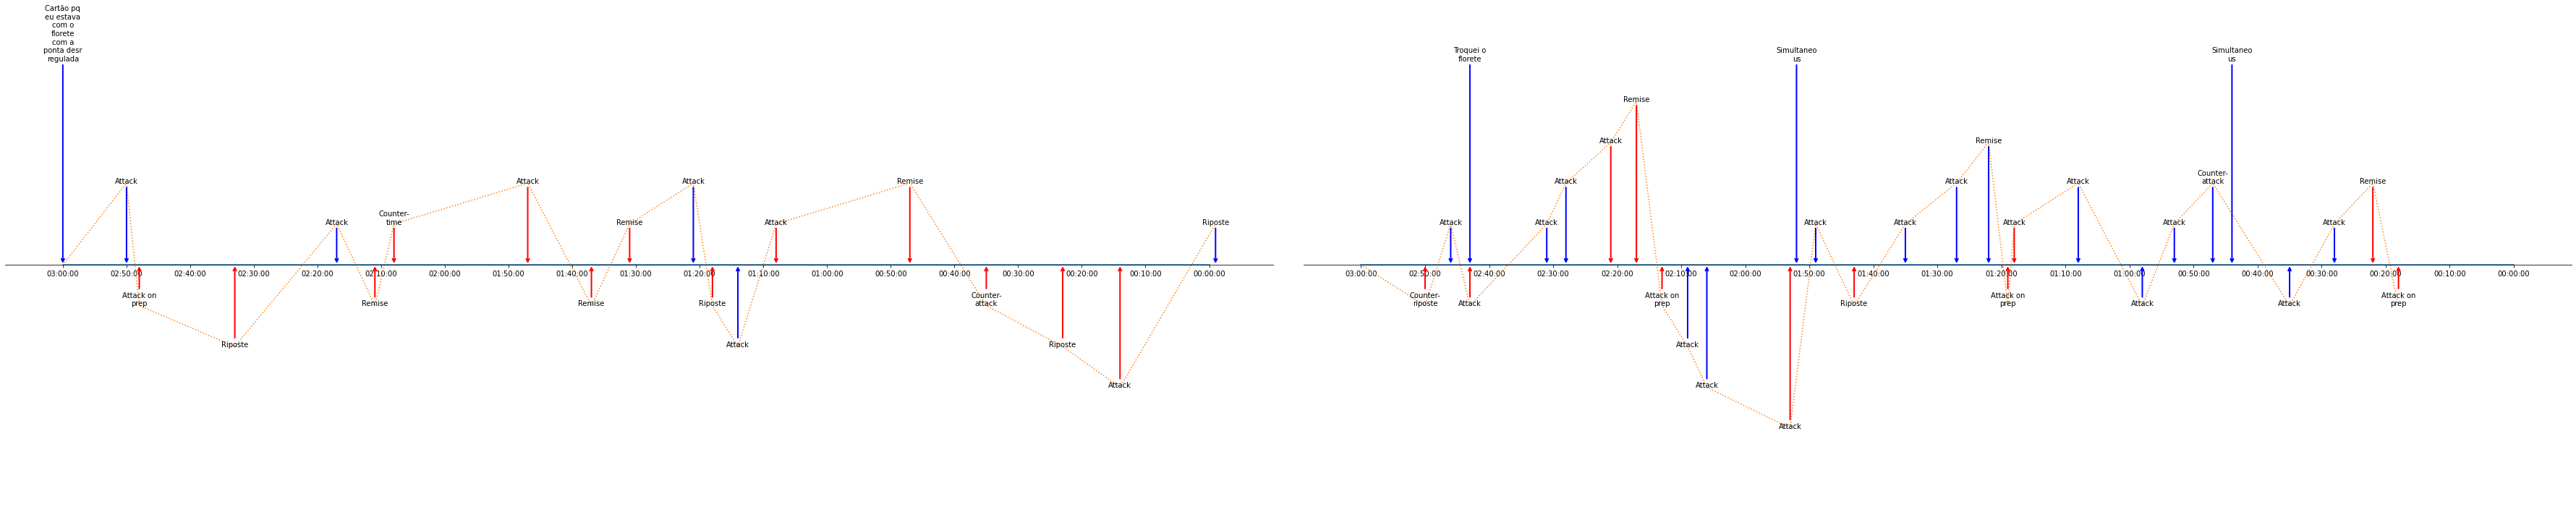

In [2]:
import matplotlib.pyplot as plt
import textwrap

# df['Level'] =  [() for perspective in df["Perspective"]]
df["Action"] = df["Action"].astype(str)
num_periods = len(set(df["Period"]))
fig, axes = plt.subplots(1, num_periods, figsize=(50, 10))
#df["X"] = df["Period"].astype(str) + ":" + df["Timestamp"]
fig.tight_layout()

for period in range(0, num_periods):
    curr_period_events = df[df["Period"] ==  period+1]
    #print(curr_period_events[["Action", "Timestamp", "Period"]])

    x_axis = []
    for seconds in range(0, 181, 1):
            minutes = seconds // 60
            seconds %= 60
            milliseconds = 0  # Assuming milliseconds are always 0 in this case
            x_axis.append(f"{minutes:02}:{seconds:02}:{milliseconds:02}")
    x_axis.reverse()

    #y_axis = [0]*len(curr_period_events)
    y_axis = [0]*len(x_axis)

    axes[period].plot(x_axis,y_axis,"")
    #axes[period].plot(curr_period_events["Timestamp"],[1]*len(curr_period_events),"o")

    x_ticks = []
    for seconds in range(0, 181, 10):
            minutes = seconds // 60
            seconds %= 60
            milliseconds = 0  # Assuming milliseconds are always 0 in this case
            x_ticks.append(f"{minutes:02}:{seconds:02}:{milliseconds:02}")
    axes[period].set_xticks(x_ticks)

    axes[period].set_ylim(-6, 6)
    axes[period].spines[["left", "top", "right"]].set_visible(False)
    axes[period].spines[["bottom"]].set_position(("axes", 0.5))
    axes[period].yaxis.set_visible(False)

    prev_fencer = ""
    streak = 0
    momentum_levels = [0]
    momentum_timestamps = ["03:00:00"]
    for index, event in curr_period_events.iterrows():
        text = event["Description"] if event["Action"] == "nan" else event["Action"]
        text = textwrap.fill(text, width=10)
        time = event["Timestamp"]
        curr_fencer = event["Perspective"]
        
        level = 1
        
        event_changes_level = event["Outcome"] in {"Hit", "Off-target", "No hit"}
        if(event_changes_level):
            #if(event["Outcome"] == "Hit"):
            streak+=1
            if(curr_fencer == prev_fencer):
                level += streak
            else:
                streak = 0
        else: 
            level = 5
        if(curr_fencer == "Against"):
            level *= -1
        if event_changes_level:
            momentum_levels.append(level)
            momentum_timestamps.append(event["Timestamp"])
        
        prev_fencer = curr_fencer
        #level = 1 if  == "For" else -1
        #level *= index % 2 + 1

        axes[period].annotate(
            text,
            xy=(time, 0),
            xytext=(time, level),
            arrowprops=dict(
                arrowstyle="->",
                linewidth=2,
                color=("red" if event["Outcome"] == "Hit" else "blue"),
            ),
            ha="center"
        )
    axes[period].plot(momentum_timestamps, momentum_levels, linestyle=':')

# Display the plot
plt.show()

# Hit distribuition

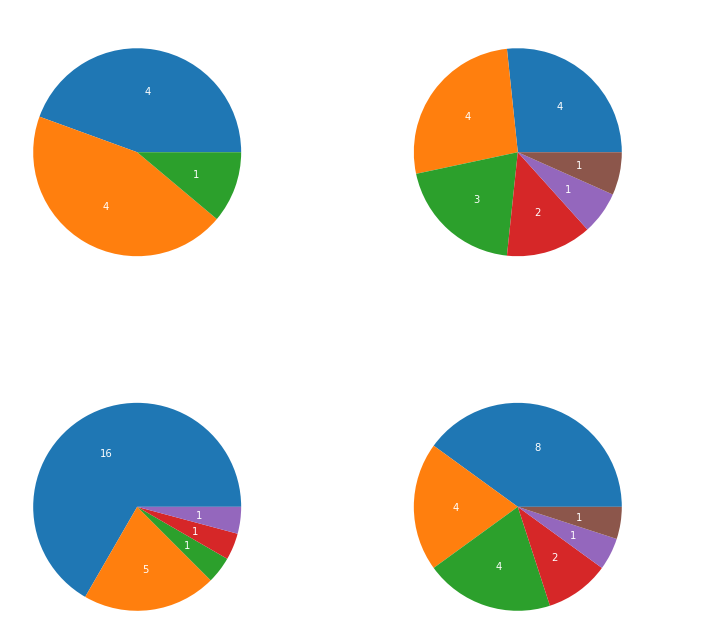

In [3]:
NON_EVENT_OUTCOMES = ['Hit', 'No hit', 'Off-target', 'No point awarded']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

pie_title = "Hit distribution"
text_color = "white"
hits = df[(df["Outcome"] == "Hit")]
my_actions = hits[(hits["Perspective"] == "For")]["Action"]
boutAnalysis.plot_pie_chart_from_column(ax1, my_actions, f'{pie_title} - Mion', text_color)
opp_actions = hits[(hits["Perspective"] == "Against")]["Action"]
boutAnalysis.plot_pie_chart_from_column(ax2, opp_actions, f'{pie_title} - Shimbo', text_color)

pie_title = "Executed actions distribuition"
executed_actions = df[df['Outcome'].isin(NON_EVENT_OUTCOMES)]
my_actions = executed_actions[(executed_actions["Perspective"] == "For")]["Action"]
boutAnalysis.plot_pie_chart_from_column(ax3, my_actions, f'{pie_title} - Mion', text_color)
opp_actions = executed_actions[(executed_actions["Perspective"] == "Against")]["Action"]
boutAnalysis.plot_pie_chart_from_column(ax4, opp_actions, f'{pie_title} - Shimbo', text_color)

plt.tight_layout()
plt.show()



# Accuracy

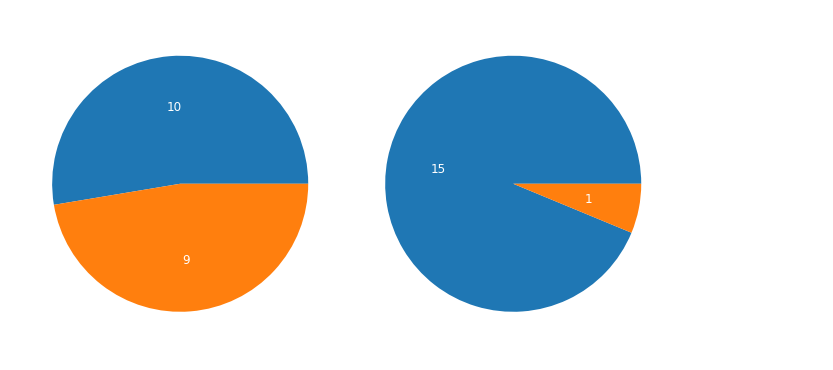

In [4]:
plt.rcParams.update({'font.size': 12})

hits_and_off_targets = df[(df["Outcome"] == "Hit") | (df["Outcome"] == "Off-target")]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
outcome_for = hits_and_off_targets[hits_and_off_targets["Perspective"] == "For"]["Outcome"]
boutAnalysis.plot_pie_chart_from_column(ax1, outcome_for, "Mion", text_color)
outcome_agg = hits_and_off_targets[hits_and_off_targets["Perspective"] == "Against"]["Outcome"]
boutAnalysis.plot_pie_chart_from_column(ax2, outcome_agg, "Shimbo", text_color)

acc_for = len(outcome_for[outcome_for == "Hit"])/len(outcome_for)
fig.text(0, 0, f'Mion: {boutAnalysis.to_percentage_str(acc_for)}', color=text_color)

acc_agg = len(outcome_agg[outcome_agg == "Hit"])/len(outcome_agg)
fig.text(1, 0, f'Shimbo: {boutAnalysis.to_percentage_str(acc_agg)}', color=text_color)

plt.tight_layout()
plt.show()


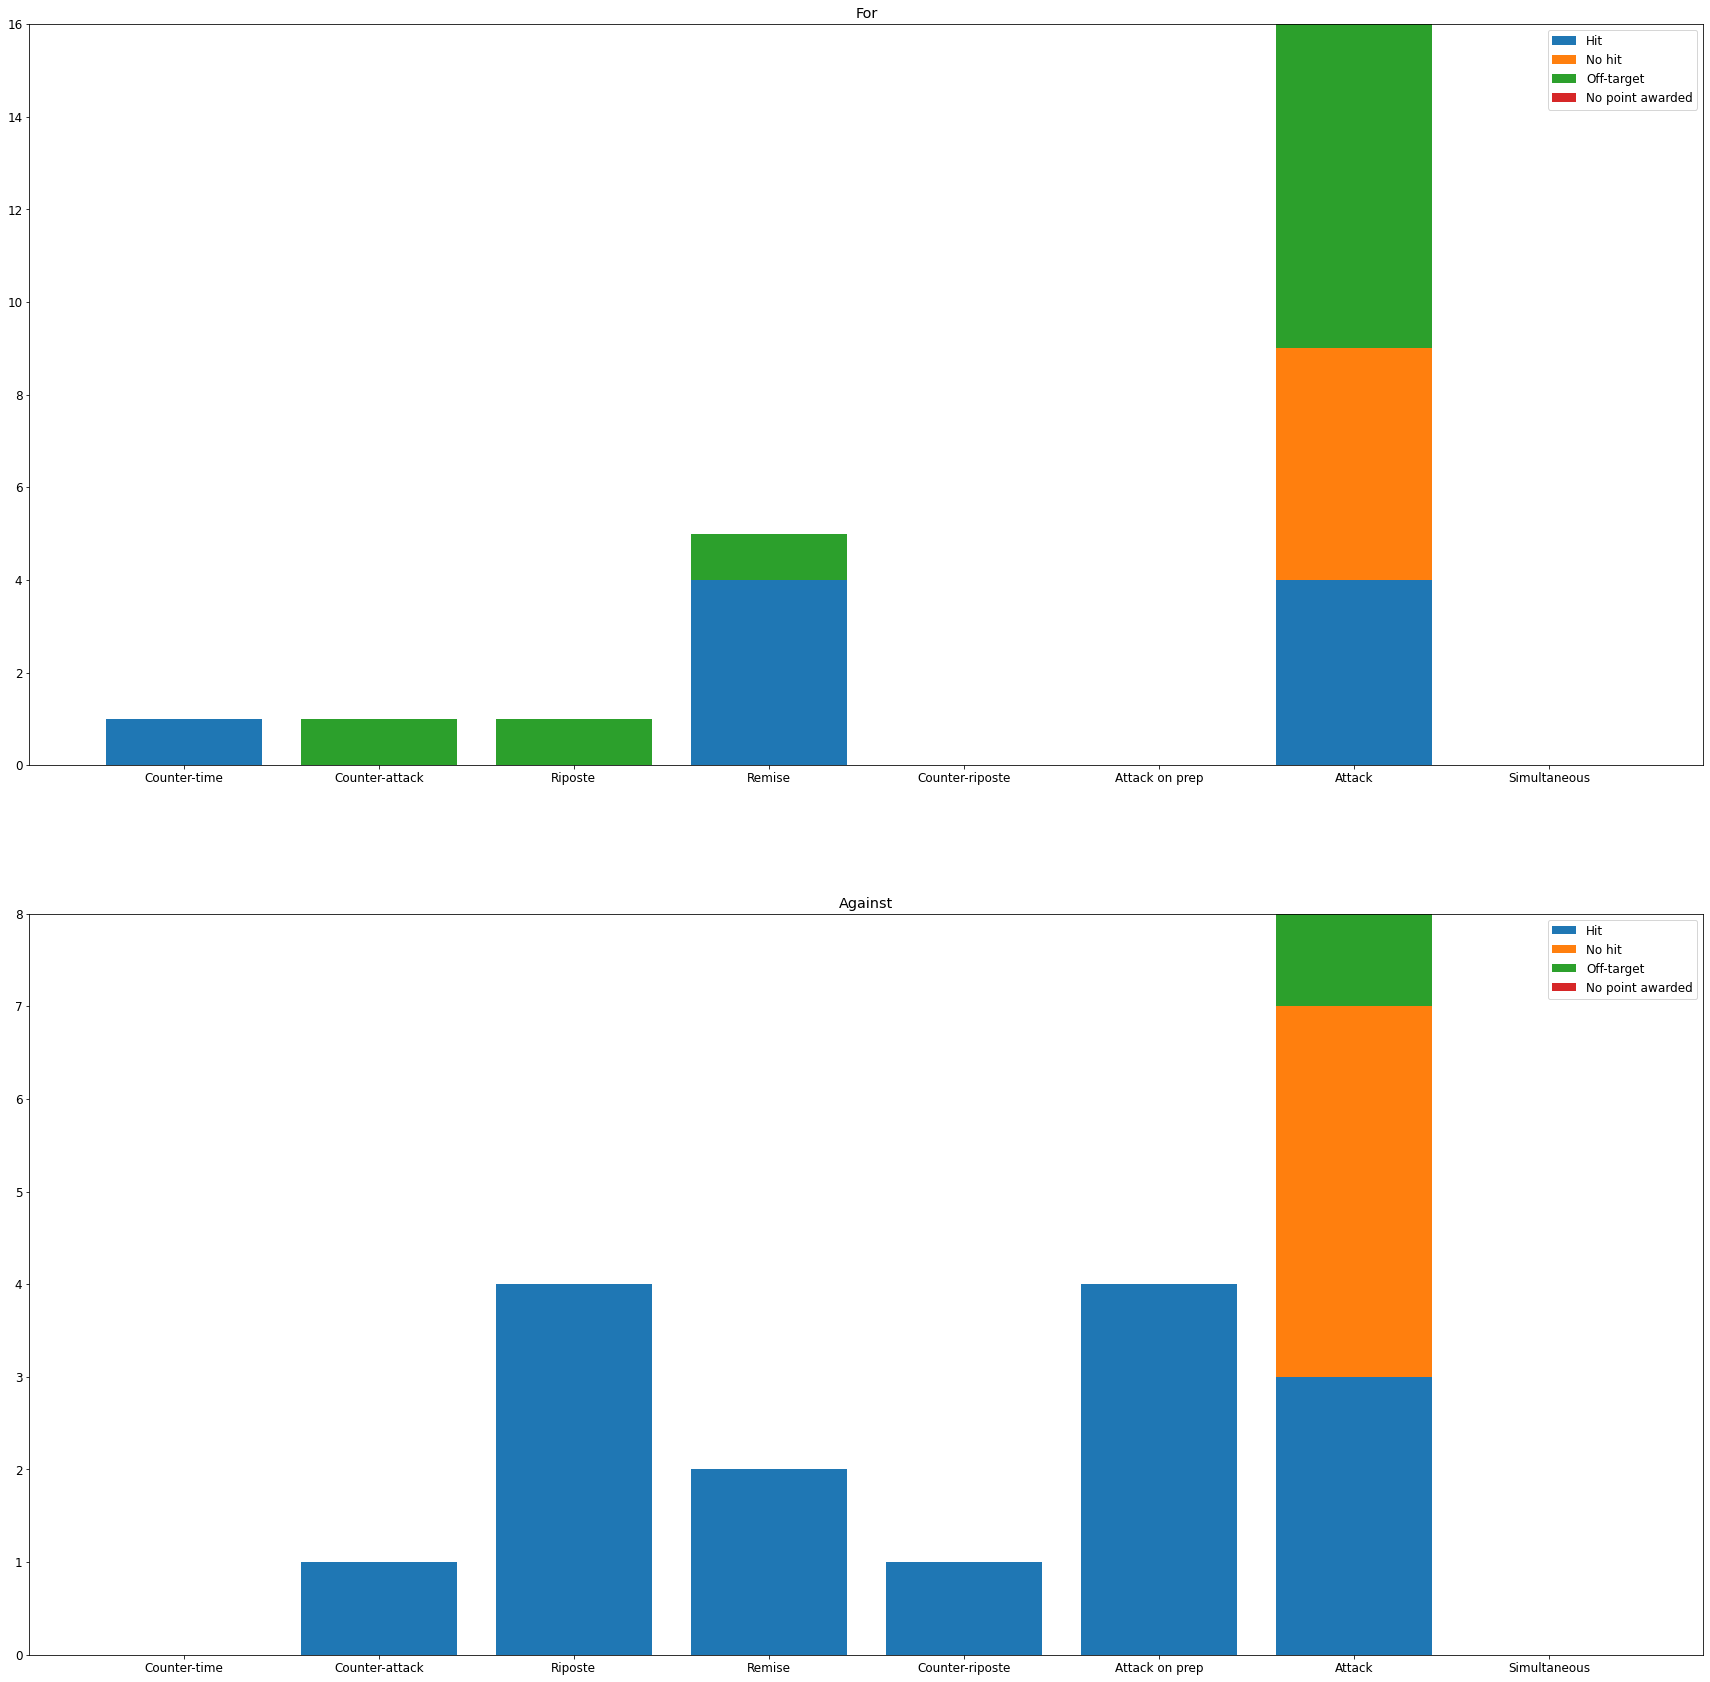

In [5]:
#ACTION_NAMES = set(df[df['Outcome'].isin(NON_EVENT_OUTCOMES)]['Action'])
ACTION_NAMES = boutAnalysis.get_unique_column_names(df, "Action", "Outcome", NON_EVENT_OUTCOMES)

fig, axes = plt.subplots(2, 1, figsize=(30, 30))

fencers = ['For', 'Against']
for index, fencer in enumerate(fencers):
    bottom = [0]*len(ACTION_NAMES)
    for outcome in NON_EVENT_OUTCOMES:
        action_counts = {}
        for action in ACTION_NAMES:
            desired_rows = df[(df['Action'] == action) & (df['Outcome'] == outcome) & (df['Perspective'] == fencer)]
            #print(desired_rows.head())
            #print(desired_rows[["Outcome", "Action", "Timestamp"]].head())
            curr_action_rows = desired_rows
            action_count = len(curr_action_rows)
            action_counts[action] = action_count
        axes[index].bar(action_counts.keys(), action_counts.values(), label=outcome, bottom=bottom)
        action_counts_values = list(action_counts.values())
        for i in range(len(bottom)):
            bottom[i] += action_counts_values[i]
    axes[index].legend()
    axes[index].set_title(fencer)
plt.show() 

# Effectiveness of offense and defense

For OFFENSIVE 9/32 (28.12%)
For DEFENSIVE 0/7 (0.00%)
Against OFFENSIVE 5/10 (50.00%)
Against DEFENSIVE 10/19 (52.63%)


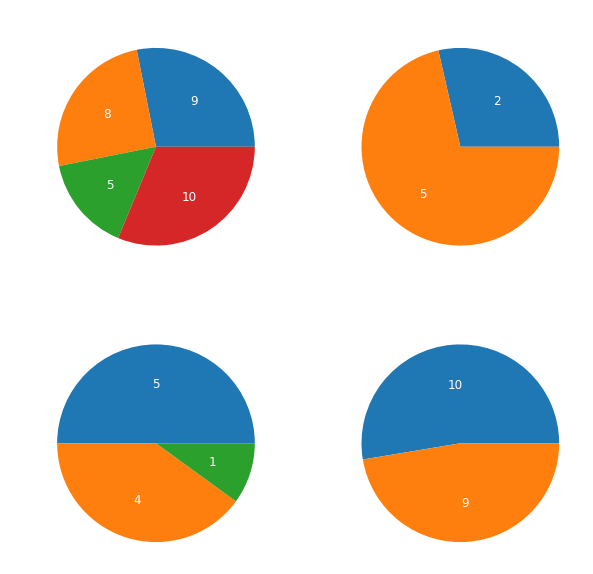

In [6]:
from dataclasses import dataclass, field

ACTION_CLASSIFICATIONS = ["OFFENSIVE", "DEFENSIVE"]

"""
@dataclass
class Action:
    classification:ActionClassification = field(init=False)
    name: str

    def __post_init__(self):
        self.classification = classify_action(self.name)

    def __str__(self):
        return f'{self.name} ({self.classification.value})'
"""
# df["Action class"] = [Action(action_name) if action_name != "nan" else None for action_name in df["Action"]]

# actions = df[df['Outcome'].isin(NON_EVENT_OUTCOMES) & (df["Action"] != "Simultaneous")].copy()
actions = df.query(
    '(Outcome in @NON_EVENT_OUTCOMES) and (Action != "Simultaneous")'
).copy()

actions["Action classification"] = actions["Action"].apply(boutAnalysis.classify_action)
actions["Counter action classification"] = actions["Counter action"].apply(
    boutAnalysis.classify_action
)

"""
class OutcomeCounts(dict):
    def __init__(self):
        self["Off-target"] = 0
        self["Hit"] = 0
        self["Failed"] = 0
        self["No hit"] = 0

    def __init__(self, dict: dict):
        for key, value in dict.items():
            self[key] = value

    def __setitem__(self, __key: OutcomeCountsKeys, __value: int) -> None:
        if type(__key) != OutcomeCounts:
            raise TypeError(f'{__key} must be in {OutcomeCountsKeys}')
        if not isinstance(__value, int):
            raise TypeError(f'{__value} must be an int')
        return super().__setitem__(__key, __value)
"""
"""
def get_outcomes(perspective: str, classification_or_action: str) -> dict:
    column_name = ''
    failed_column_name = ''
    if classification_or_action in ACTION_CLASSIFICATIONS:
        column_name = "Action classification"
        failed_column_name = "Counter action classification"
    elif classification_or_action in ACTION_NAMES:   
        column_name = "Action"
        failed_column_name = "Counter action"
    else:
        raise Exception(f'{classification_or_action} not recognized')

    print(column_name, classification_or_action)
    print(actions["Action classification"].head())
    query = f"`{column_name}` == '@classification_or_action' and Perspective == @perspective"
    print(query)
    outcome_counts =dict(
        actions.query(
            query
        )["Outcome"].value_counts()
    )

    print(failed_column_name, classification_or_action)

    num_failed = len(actions.query(
        f"Perspective != @perspective and `{failed_column_name}` == '@classification_or_action' and Outcome == 'Hit'"
    ))

    outcome_counts["Failed"] = num_failed

    return outcome_counts
"""


fig, (axes) = plt.subplots(2, 2, figsize=(10, 10))

for fencer, ax_list in zip(fencers, axes):
    
    for classification, ax in zip(["OFFENSIVE", "DEFENSIVE"], ax_list):
        outcome_counts = boutAnalysis.get_classification_outcomes(actions, fencer, classification)
        boutAnalysis.plot_pie_chart_from_dict(ax, outcome_counts, f"{fencer}, {classification}", text_color)
        print(fencer, classification, boutAnalysis.get_effectiveness_info_str(outcome_counts))

plt.show()

For Counter-time 1/1 (100.00%)
Against Counter-time not performed
For Counter-attack 0/1 (0.00%)
Against Counter-attack 1/4 (25.00%)
For Riposte 0/2 (0.00%)
Against Riposte 4/7 (57.14%)
For Remise 4/7 (57.14%)
Against Remise 2/2 (100.00%)
For Counter-riposte not performed
Against Counter-riposte 1/1 (100.00%)
For Attack on prep not performed
Against Attack on prep 4/5 (80.00%)
For Attack 4/24 (16.67%)
Against Attack 3/8 (37.50%)
For Simultaneous not performed
Against Simultaneous not performed
11 graphs


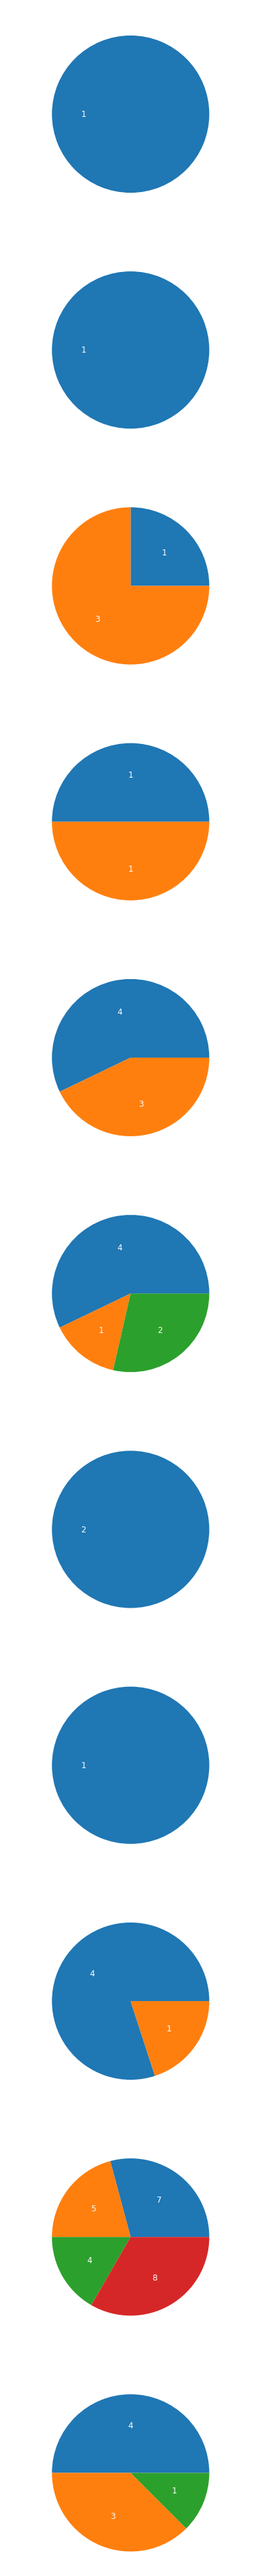

In [7]:
chart_data_list = []
for action in ACTION_NAMES:
    for fencer, ax in zip(fencers, ax_list):
        outcome_counts = boutAnalysis.get_action_outcomes(actions, fencer, action)
        if(sum(outcome_counts.values()) != 0):
            chart_data_list.append({
                "outcome_counts": outcome_counts,
                "action": action,
                "fencer": fencer
            })
            #plot_pie_chart_from_dict(ax, outcome_counts, f"{fencer}, {action}", "black")
            action_effective_ness = boutAnalysis.calc_effectiveness(outcome_counts)
            print(fencer, action, boutAnalysis.get_effectiveness_info_str(outcome_counts))
        else:
            print(fencer, action, "not performed")

fig, (axes) = plt.subplots(len(chart_data_list), 1, figsize=(50, 70))
print(f'{len(chart_data_list)} graphs')

for chart_data, ax in zip(chart_data_list, axes):
    boutAnalysis.plot_pie_chart_from_dict(ax, chart_data["outcome_counts"], f"{chart_data['fencer']}, {chart_data['action']}", text_color)
    
plt.show()

In [9]:
COUNTER_ACTION_NAMES = boutAnalysis.get_unique_column_names(df, "Counter action", "Outcome", NON_EVENT_OUTCOMES)
print(COUNTER_ACTION_NAMES)

PARRIES = boutAnalysis.get_unique_column_names(df, "Parry", "Outcome", NON_EVENT_OUTCOMES)
print(PARRIES)

parry_rows = df[df["Parry"].isin(PARRIES)]
print(parry_rows)

['Avoid with distance', 'Counter-attack', 'Riposte', 'Remise', 'Attack on prep', 'Attack', 'Simultaneous', 'Parry']
['7', 'C4', 'C6', '4', 'C6-8', '8', '6']
   Timestamp Perspective     Outcome  \
32  02:33:00     Against         Hit   
34  02:11:00     Against         Hit   
35  02:08:00         For         Hit   
36  01:47:00         For         Hit   
38  01:31:00         For         Hit   
39  01:21:00         For  Off-target   
40  01:18:00     Against         Hit   
41  01:14:00     Against      No hit   
43  00:47:00         For         Hit   
45  00:23:00     Against         Hit   
46  00:14:00     Against         Hit   
47  00:00:41         For  Off-target   
0   02:50:00     Against         Hit   
3   02:43:00     Against         Hit   
5   02:28:00         For  Off-target   
9   02:09:00     Against  Off-target   
11  01:53:00     Against         Hit   
13  01:49:00         For  Off-target   
14  01:43:00     Against         Hit   
16  01:27:00         For      No hit   
17 